In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl


In [2]:
class CNA(nn.Module):
    def __init__(self,in_cn,out_cn,stride=1):
        super().__init__()
        self.act = nn.ReLU()
        self.conv = nn.Conv2d(in_cn, out_cn, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_cn)

    def forward(self,x):
        feat = self.conv(x)
        feat = self.norm(feat)
        feat = self.act(feat)
        return feat
        

In [3]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()
        
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        
        self.cna3 = CNA(nc, nc)
        
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        return out

    
        
        
        

In [4]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        
        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out
    

In [5]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),

        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        ToTensorV2(),
    ]
)

In [6]:

ds_images_path = 'D:\\datasets\\segmentation_full_body_mads_dataset_1192_img\\images'
ds_masks_path = 'D:\\datasets\\segmentation_full_body_mads_dataset_1192_img\\masks'

In [7]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        
        self.images_filenames = sorted(os.listdir(self.images_directory))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))
            
        return image, mask

In [9]:
data = SegmentationDataset(
    images_directory=ds_images_path,
    masks_directory=ds_masks_path,
    transform=A.Compose(
        [A.Resize(height=256, width=256), A.pytorch.transforms.ToTensorV2()]
    ),
)

In [10]:
train_size = 0.9
train_len = math.floor(len(data)*train_size)
val_len = len(data) - train_len
train_dataset ,val_dataset = torch.utils.data.random_split(data,[train_len,val_len])

In [11]:
print(train_len)

1072


In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,shuffle=True,batch_size=8,pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,shuffle=False,batch_size=8,pin_memory=True)



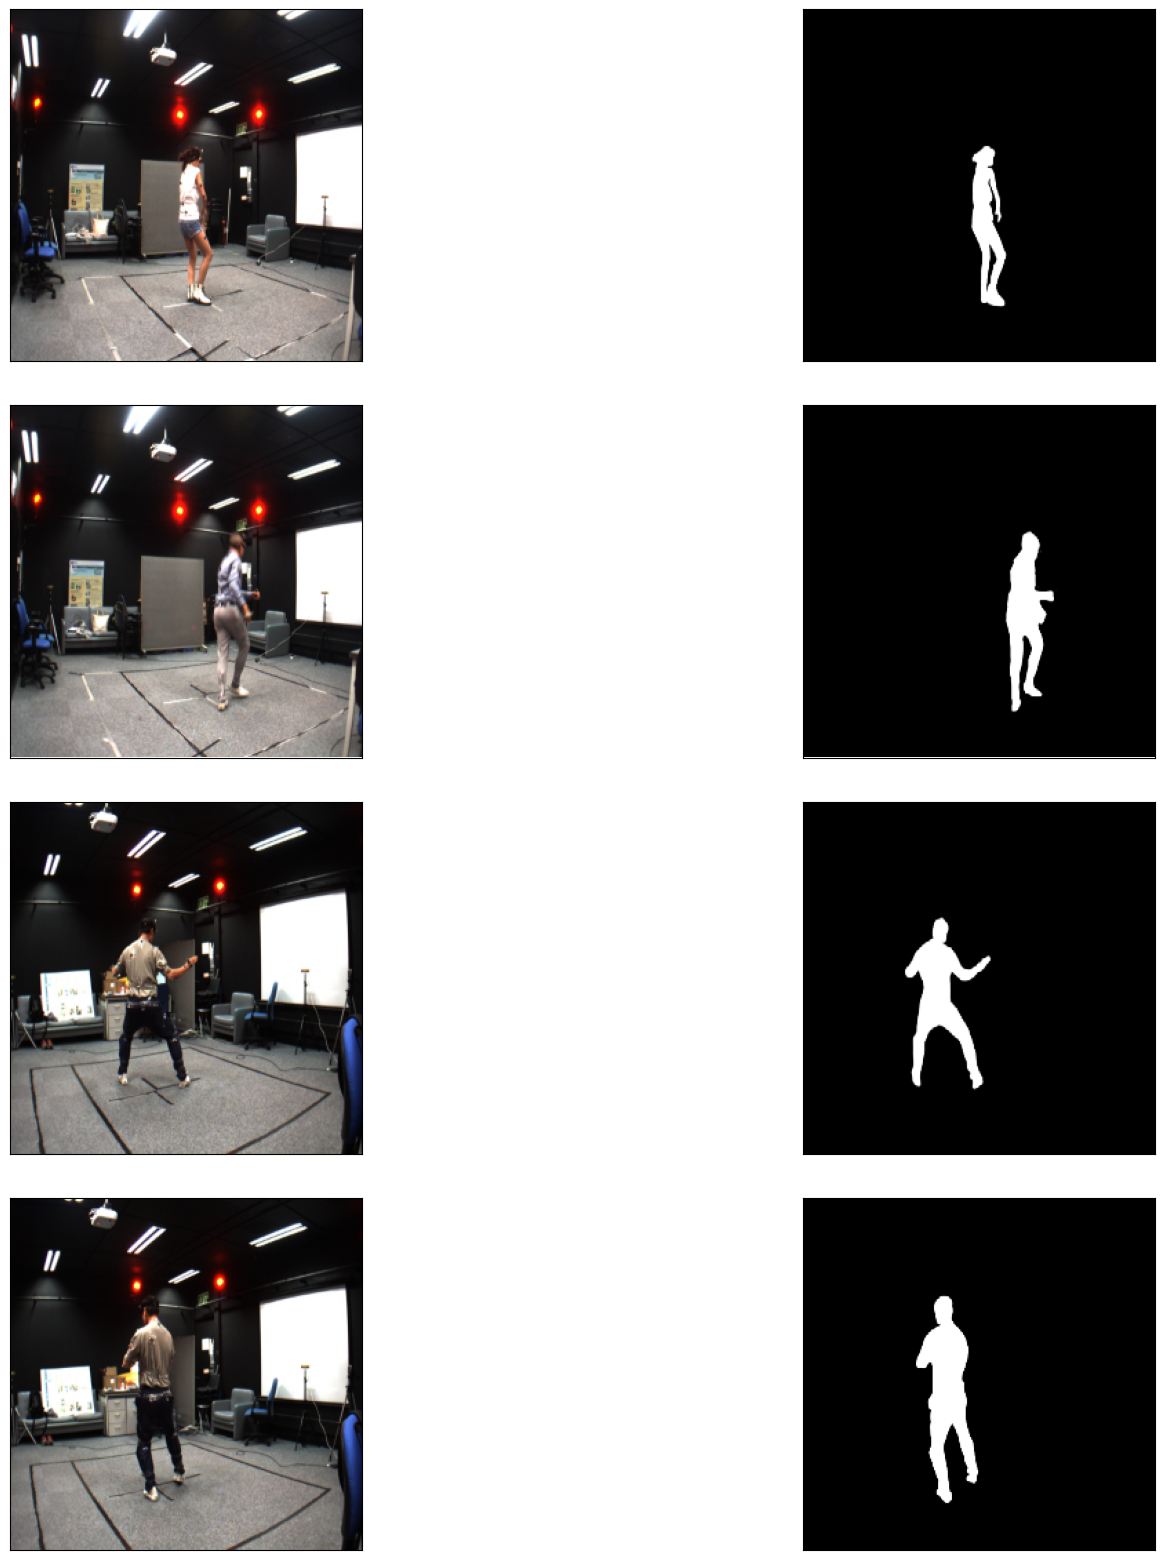

In [38]:
def im_show(img_list) -> None:
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for idx, sample in enumerate(img_list):
        img, label = sample


        if img.ndim == 4:
            img = img[0]  
        if label.ndim == 4:
            label = label[0]  


        if isinstance(img, torch.Tensor):
            img = img.numpy().transpose(1, 2, 0) 
        if isinstance(label, torch.Tensor):
            label = label.numpy().squeeze()  

        axes[idx][0].imshow(img)
        axes[idx][1].imshow(label, cmap='gray')  

        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append((img, label))

im_show(img_list)

In [39]:
class SimpleModule(pl.LightningModule):
    def __init__(self, in_nc, nc, out_nc, num_downs):
        super().__init__()
        self.model = Unet(in_nc, nc, out_nc, num_downs)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.num_correct = 0
        self.num_pixels = 0
        self.training_step_outputs = []
        self.training_step_dice = []
        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.validation_step_outputs = []
        self.validation_step_dice = []

    def training_step(self, batch: torch.Tensor, batch_idx):
        x, y = batch
        pred = self.model(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.training_step_dice.append((2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8))
        self.log("train_loss", loss, prog_bar=True)
        self.training_step_outputs.append(loss)
        return {"loss": loss}

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        train_acc = float(f"{(self.num_correct/self.num_pixels)*100:.2f}")
        self.log("train_acc", train_acc, prog_bar=True)
        dice_score = torch.stack(self.training_step_dice).mean()
        self.log("train_dice_score", dice_score, prog_bar=True)
        self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0
        self.training_step_outputs.clear()
        self.training_step_dice.clear()

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        pred = self.model(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.validation_step_dice.append((2 * (pred * y).sum()) / ((pred + y).sum() + 1e-8))
        self.log("val_loss", loss, prog_bar=True)
        self.validation_step_outputs.append(loss)
        return {"loss": loss}

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        val_acc = float(f"{(self.val_num_correct / self.val_num_pixels) * 100:.2f}")
        self.log("val_acc", val_acc, prog_bar=True)
        dice_score = torch.stack(self.validation_step_dice).mean()
        self.log("val_dice_score", dice_score, prog_bar=True)
        self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0
        self.validation_step_outputs.clear()
        self.validation_step_dice.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

In [17]:
unet_lightning_model = SimpleModule(in_nc=3, nc=32, out_nc=1, num_downs=5)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1
)

trainer.fit(unet_lightning_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\kirvi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Unet              | 8.4 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
8.4 M     Trainable params
0

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\kirvi\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\kirvi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\kirvi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functio

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


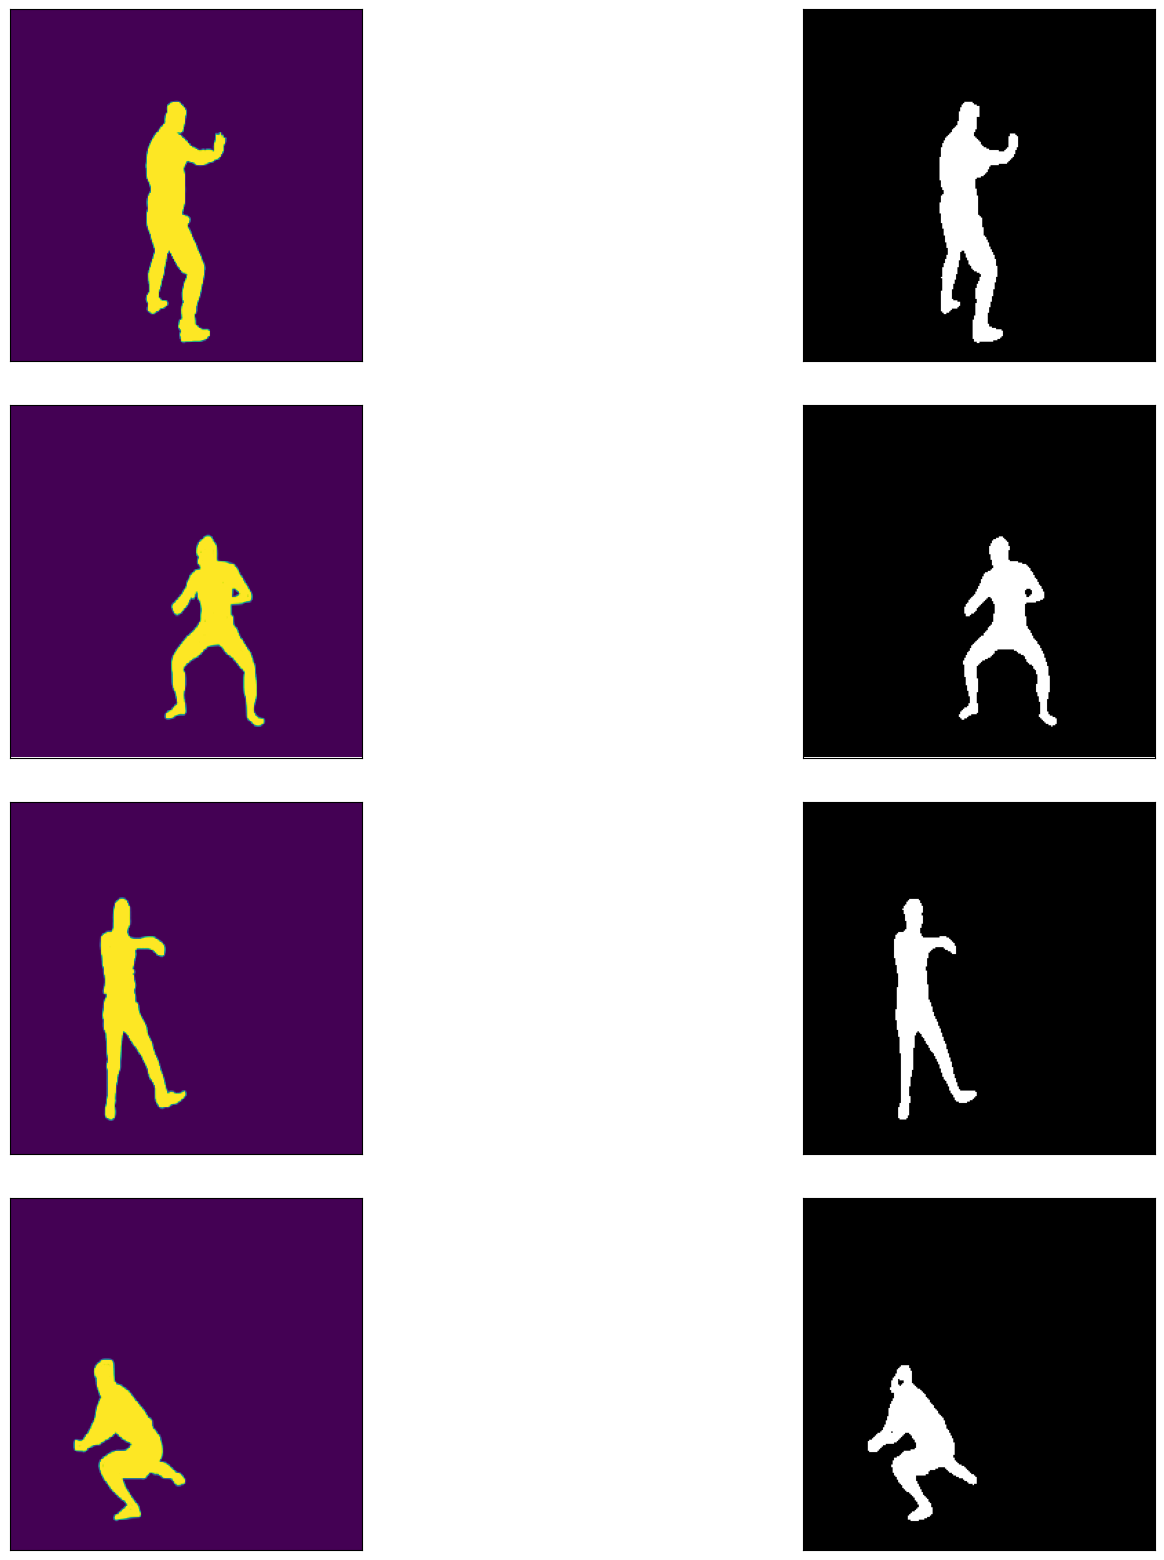

In [40]:
def predict_img(
    net: nn.Module, img: torch.Tensor, device: str, out_threshold: float = 0.5
) -> np.ndarray:
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
img_list = []
for i in range(4):
    img_base, img = val_dataset[np.random.randint(0, 100)]
    mask = predict_img(unet_lightning_model.model, img_base,device=device)
  
    img_list.append((img, mask))
im_show(img_list)